One of those things that you can't control, when a laptop crash sets you back by two weeks. Anyway, here we are.

Try a vanilla GCN on the formulated GRL problem and analyse the results. 

What all is useful here:
- orig_members: member_id (763)
- orig_inline_notifications: notify_from_id, notify_to_id (47066)
- orig_message_topic_user_map: map_user_id, map_topic_id (6025)
- orig_message_topics: mt_starter_id, mt_to_member_id, mt_id (3101)
- orig_reputation_index: member_id (141550)

NOTE: Make sure to adjust some inconsistencies in members before trying out GRL.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import requests 
import io
import seaborn as sns

Graph Formulation:

**Nodes**: Members (total 763)

**Node Features**: (the node label for classification)
- Reputation Value 

**Edges**: (both can be treated as directed edges)
- Notifications (total 47066)
- Private Messages (total 3101)

In [3]:
PATH = '../data/'
files = os.listdir(PATH)
dfs = {f[:-4] : pd.read_csv(PATH + f) 
           for f in files if f[-3:] == 'csv'
}

Now, we need to fit this problem into the Vanilla GCN implementation by Kipf!

In [4]:
# first, make Python lists of all the relevant data
members = sorted(list(dfs['orig_members'].member_id))

In [5]:
# we'll need to shift them all to 1..N
members[:20]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 20, 22, 23]

In [6]:
dfs['orig_members'].shape

(763, 74)

In [7]:
reputation = [[m, sum(dfs['orig_reputation_index'].member_id == m)]
              for m in members]

In [8]:
# maybe using 17.0 as the cutoff
just_reps = [reputation[z][1] for z in range(reputation.__len__())]
med_reps  = np.median(just_reps)
med_reps

17.0

In [9]:
labels = [int(rep > med_reps) for rep in just_reps]

In [10]:
labels[:10]

[1, 1, 1, 1, 1, 0, 1, 1, 1, 1]

In [11]:
just_reps.__len__()

763

In [12]:
notifs_raw = [[dfs['orig_inline_notifications'].notify_from_id[z], 
               dfs['orig_inline_notifications'].notify_to_id[z]]
              for z in range(dfs['orig_inline_notifications'].shape[0])]

In [13]:
notifs = [n for n in notifs_raw if (n[0] in members and n[1] in members)]

In [14]:
len(notifs_raw), len(notifs)

(47066, 47066)

In [15]:
messages_raw = [[dfs['orig_message_topics'].mt_starter_id[z], 
               dfs['orig_message_topics'].mt_to_member_id[z]]
              for z in range(dfs['orig_message_topics'].shape[0])]

In [16]:
messages = [n for n in messages_raw if (n[0] in members and n[1] in members)]

In [17]:
len(messages_raw), len(messages)

(3101, 2859)

In [18]:
notifs[:3], messages[:3]

([[9267, 9679], [9327, 6260], [8232, 9679]], [[1, 23], [11, 1], [16, 14]])

In [19]:
import torch
torch.__version__

'1.6.0'

In [20]:
# I won't use sparse matrices since 763x763 should be okay 
import numpy as np

In [21]:
# Now we want the adjacency matrix
# change to messages for a different set of edges
edges_raw = notifs  # = messages
member_index = {members[i] : i+1 for i in range(len(members))}

In [22]:
member_index[9267]

507

In [23]:
edges = [
    [member_index[node] for node in edge]
    for edge in edges_raw
]

In [24]:
num_nodes = len(members)
adjacency = [[0 for _ in range(num_nodes)] for _ in range(num_nodes)]
for edge in edges:
    adjacency[edge[0] - 1][edge[1] - 1] = 1

In [25]:
# let's try to add self loops and normalize the adjacency matrix
for i in range(len(adjacency)):
    adjacency[i][i] = 1

In [26]:
from sklearn.preprocessing import normalize

In [27]:
adjacency = np.array(adjacency)
adjacency = normalize(adjacency, norm='l1', axis=1)

In [66]:
def dataloader(adjacency, labels):
#     print(adjacency.shape)
    labels = np.array(labels)
#     print(labels.shape)
    features = featurise(labels)
    idx_train, idx_val, idx_test = train_val_test_split(adjacency.shape[0])
    data = (adjacency, features, labels, idx_train, idx_val, idx_test)
#     print([type(d) for d in data])
    data = tuple(map(lambda z: torch.from_numpy(z), data))
#     print([type(d) for d in data])
    return data

In [67]:
def train_val_test_split(num_nodes, train=0.15, val=0.15):
  idx_train = np.random.choice(range(num_nodes), int(train * num_nodes), replace=False)
  idx_vt = list(set(range(num_nodes)) - set(idx_train))
  idx_val = np.random.choice(idx_vt, int(val * num_nodes), replace=False)
  idx_test = list(set(idx_vt) - set(idx_val))
  return np.array(idx_train), np.array(idx_val), np.array(idx_test)

In [68]:
def featurise(labels, ft_type='random', size=50):
    if ft_type == 'random':
        return np.random.rand(len(labels), size)
    if ft_type == 'onehot':
        return 42                   # TODO
    if ft_type == 'uniform':
        return np.ones(len(labels), size)

In [69]:
adj, features, labels, idx_train, idx_val, idx_test = dataloader(adjacency, labels)

In [70]:
idx_train.shape, idx_val.shape, idx_test.shape

(torch.Size([114]), torch.Size([114]), torch.Size([535]))

In [71]:
features.shape

torch.Size([763, 50])

In [72]:
# untested
def accuracy(output, labels):
  preds   = output.max(1)[1].type_as(labels)
  correct = preds.eq(labels).double()
  correct = correct.sum()
  return correct / len(labels)

In [73]:
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [114]:
class GraphConv(nn.Module):

    def __init__(self, in_features, out_features):
        super(GraphConv, self).__init__()
        self.in_features  = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters()
    
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
#         print(input.dtype, adj.dtype)
        input = input.float()
        adj   = adj.float()
#         print(input.dtype, adj.dtype)
        support = torch.mm(input, self.weight)
        output = torch.mm(adj, support)     # permutation inv sum of all neighbor features
        return output + self.bias

    def __repr__(self):
        return self.__class__.__name__ +' ('+str(self.in_features)+' -> '+str(self.out_features)+')'

In [115]:
class VanillaGCN(nn.Module):

    def __init__(self, nfeat, nhid, nclass, dropout):
        super(VanillaGCN, self).__init__()
        self.gc1 = GraphConv(nfeat, nhid)
        self.gc2 = GraphConv(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

In [116]:
CUDA = torch.cuda.is_available()
SEED = 42
torch.manual_seed(SEED)
if CUDA: torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

In [117]:
CUDA

False

In [134]:
# hyperparameters
# lr = 0.01
lr = 0.03
# epochs = 200
epochs = 200
wd = 5e-4
hidden = 16
dropout = 0.5
fastmode = False

In [135]:
# instantiate the model and optimizer
model = VanillaGCN(
    nfeat   = features.shape[1], 
    nhid    = hidden, 
    nclass  = labels.max().item() + 1, 
    dropout = dropout
)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [136]:
# move the data and model to the GPU 
if CUDA:
  model.cuda()
  features = features.cuda()
  adj = adj.cuda()
  labels = labels.cuda()
  idx_train = idx_train.cuda()
  idx_val = idx_val.cuda()
  idx_test = idx_test.cuda()

In [137]:
def train(epoch):
  t = time.time()
  model.train()
  optimizer.zero_grad()
  output = model(features, adj)
  loss_train = F.nll_loss(output[idx_train], labels[idx_train])
  acc_train = accuracy(output[idx_train], labels[idx_train])
  loss_train.backward()
  optimizer.step()
  if not fastmode:
      model.eval()
      output = model(features, adj)
  loss_val = F.nll_loss(output[idx_val], labels[idx_val])
  acc_val = accuracy(output[idx_val], labels[idx_val])
  if epoch % 10 == 0:
    print('Epoch: {:04d}'.format(epoch+1),
        'loss_train: {:.4f}'.format(loss_train.item()),
        'loss_val: {:.4f}'.format(loss_val.item()),
        'acc_val: {:.4f}'.format(acc_val.item()))
  return loss_train.item(), loss_val.item()

In [138]:
def test():
  model.eval()
  output = model(features, adj)
  loss_test = F.nll_loss(output[idx_test], labels[idx_test])
  acc_test = accuracy(output[idx_test], labels[idx_test])
  print("Test set results:",
        "loss= {:.4f}".format(loss_test.item()),
        "accuracy= {:.4f}".format(acc_test.item()))

In [139]:
import time
t_total = time.time()
train_losses, val_losses = [], []
for epoch in range(epochs):
  loss_train, loss_val = train(epoch)
  train_losses.append(loss_train)
  val_losses.append(loss_val)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

Epoch: 0001 loss_train: 1.4499 loss_val: 0.9450 acc_val: 0.4123
Epoch: 0011 loss_train: 0.7293 loss_val: 0.7081 acc_val: 0.4123
Epoch: 0021 loss_train: 0.6955 loss_val: 0.6906 acc_val: 0.5877
Epoch: 0031 loss_train: 0.6743 loss_val: 0.7193 acc_val: 0.4123
Epoch: 0041 loss_train: 0.6755 loss_val: 0.7182 acc_val: 0.4123
Epoch: 0051 loss_train: 0.6576 loss_val: 0.7313 acc_val: 0.3772
Epoch: 0061 loss_train: 0.6359 loss_val: 0.7293 acc_val: 0.4211
Epoch: 0071 loss_train: 0.6177 loss_val: 0.7263 acc_val: 0.4386
Epoch: 0081 loss_train: 0.6414 loss_val: 0.7511 acc_val: 0.4825
Epoch: 0091 loss_train: 0.5872 loss_val: 0.7395 acc_val: 0.5702
Epoch: 0101 loss_train: 0.5767 loss_val: 0.7894 acc_val: 0.4825
Epoch: 0111 loss_train: 0.6167 loss_val: 0.7916 acc_val: 0.5702
Epoch: 0121 loss_train: 0.5766 loss_val: 0.8321 acc_val: 0.5351
Epoch: 0131 loss_train: 0.5805 loss_val: 0.8779 acc_val: 0.4561
Epoch: 0141 loss_train: 0.5978 loss_val: 0.9197 acc_val: 0.4298
Epoch: 0151 loss_train: 0.6036 loss_val:

In [140]:
test()

Test set results: loss= 0.8526 accuracy= 0.5888


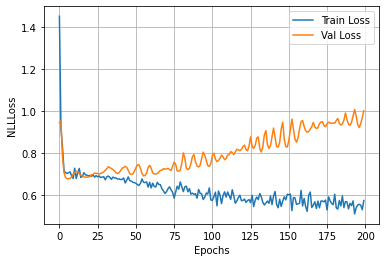

In [141]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('NLLLoss')
plt.legend()